<a href="https://colab.research.google.com/github/Shona173/codes/blob/main/Comparing_algorithm_OT_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install POT
!pip install trimesh
!pip install pyrender
!pip install ffmpeg-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 711.2/711.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.3 MB/s eta 0:00:00
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745193 sha256=2b6e96eff7c78c4a91928e00388cd76758f717d307e1079d545748bff85abfb6
  Stored in directory: /root/.cache/pip/wheels/2f/37/f5/f88cd3dddf75bc3ce608e44bf8a79078c408bf1f351a50818e
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.9
    Uninstalling PyOpenGL-3.1.9:
      Successfully uninstalled PyOpenGL-3.1.9


In [4]:
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt
import skimage.measure
import trimesh
import pyrender
import matplotlib.animation as animation
from google.colab import files
from matplotlib import animation
from scipy.ndimage import gaussian_filter
from IPython.display import HTML
import ot
import os
import time

In [5]:
def clamp(value, min_val, max_val):
    return np.maximum(min_val, np.minimum(value, max_val))

In [6]:
def sdf_circle(x, r=0.5):
    return np.sqrt(np.sum(x**2, axis=1)) - r

In [17]:
def sdf_to_distribution(f_sdf, grid, grid_size):
    vals = f_sdf(grid)
    mask = (vals < 0).astype(np.float32)
    normed = mask / np.sum(mask)
    return normed.reshape((grid_size, grid_size, grid_size))

In [25]:
def sdf_box2D(p, b=[0.7,0.7]):
    p = p.copy()
    d = np.abs(p)-b
    max_d = np.maximum(d, 0.0)
    length_d = np.sqrt(np.sum(max_d**2, 1))
    return length_d + np.minimum(np.maximum(d[:,0], d[:,1]), 0.0)

In [8]:
def sdf_sphere(p, s=0.5):
    p = p.copy()
    return np.sqrt(np.sum(p**2, axis=1))-s

In [24]:
def sdf_box3D(p, b=[0.5,0.5,0.5]):
    p2 = p.copy()
    q = np.abs(p2) - b
    q2 = np.maximum(q, 0.0)
    q2 = np.linalg.norm(q2, axis=1, ord=2)
    q3 = np.minimum(np.maximum(q[:,0], np.maximum(q[:,1], q[:,2])), 0.0)
    return q2 + q3

In [10]:
def r_union(f1, f2):
    return f1 + f2 + np.sqrt(f1**2 + f2**2)

In [11]:
def r_intersection(f1,f2):
  return f1+f2-np.sqrt(f1**2+f2**2)

In [12]:
def entropy(mu, a):
    mu_safe = np.maximum(mu, 1e-8)
    return -np.sum(a * mu_safe * np.log(mu_safe))

In [13]:
def convolution_operator(volume, sigma):
    return gaussian_filter(volume, sigma=sigma, mode='constant')

In [19]:
def gen_grid(resolution, low=-1.0, high=1.0):
    idx = np.linspace(low, high, num=resolution)
    x, y = np.meshgrid(idx, idx)
    V = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1))), 1)

    return V

In [21]:
def sample_and_normalize(f, grid, grid_size):
    '''
    Sample f on the grid and normalize it.
    Assume f>0 outside and <0 inside.
    '''
    print(grid.shape)
    fv = f(grid)
    print(fv.shape)

    # >0 inside
    fv = -fv
    #If value of return to SDF function is minus, this function can't use.


    # f is the characteristic function for {f>0}
    fv[fv>=0.0] = 1.0
    fv[fv<0.0] = 0.0

    total_sum = np.sum(fv)
    if total_sum > 0:
        fv = fv / total_sum
    else:
        raise ValueError("The sum of the function values is zero; normalization is not possible.")

    # reshape to have the same shape as grid
    fv = fv.reshape(grid_size, grid_size)

    return fv

OT using library(bregman.convolutional_barycenter2d)

(4096, 2)
(4096,)
(4096, 2)
(4096,)


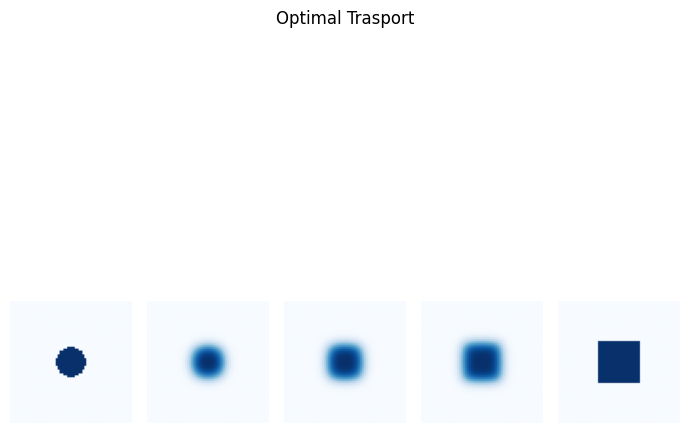

0.44227147102355957


In [26]:
start=time.time()
grid_size = 64
grid = gen_grid(grid_size,-2.0,2.0)

# f1 and f2 are prob. distribution corresponding to f1 and f2
f1 = sample_and_normalize(sdf_circle, grid, grid_size)
f2 = sample_and_normalize(sdf_box2D, grid, grid_size)

A = np.array([f1,f2])

nb_images = 5
reg = 0.004

v1 = np.array((1, 0))
v2 = np.array((0, 1))

fig, axes = plt.subplots(1, nb_images, figsize=(7, 7))
plt.suptitle("Optimal Trasport")
cm = "Blues"

for i in range(nb_images):
    tx = float(i) / (nb_images - 1)

    weights = (1 - tx) * v1 + tx * v2

    if i == 0:
        axes[i].imshow(f1, cmap=cm)
    elif i == (nb_images - 1):
        axes[i].imshow(f2, cmap=cm)
    else:
        # call to barycenter computation
        axes[i].imshow(
            ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm
        )
    axes[i].axis("off")
#Optimal Trasport
plt.tight_layout()
plt.show()
end=time.time()
print(end-start)

In [27]:
def export_volume_to_obj(volume,level, bounds, output_file):
    min_val = np.min(volume)
    max_val = np.max(volume)

    if max_val-min_val < 1e-6:
        print("Volume fluctuations are too small")
        return

    level = min_val + 0.5 * (max_val - min_val)

    try:
      verts, faces, normals, _ = skimage.measure.marching_cubes(volume, level=level)
    except RuntimeError as e:
        print("marching_cubes failed: {e}")
        return

    scale = (bounds[1] - bounds[0]) / (volume.shape[0] - 1)
    verts = verts * scale + bounds[0]

    mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
    mesh.export(output_file)

In [28]:
def conv_ot_barycenter(mu_list, alpha, K, niter=100, eps=1e-8):

    mu_list = [mu / np.sum(mu) for mu in mu_list]
    alpha = np.array(alpha, dtype=np.float32)
    alpha = alpha / np.sum(alpha)

    shape = mu_list[0].shape
    v_list = [np.ones(shape, dtype=np.float32) for _ in mu_list]
    bary = np.ones(shape, dtype=np.float32)

    for _ in range(niter):
        w_list = []
        d_list = []

        for i in range(len(mu_list)):
            KT_v = K(v_list[i])
            w = mu_list[i] / (KT_v + eps)
            d = v_list[i] * K(w)
            d = np.maximum(d, eps)
            w_list.append(w)
            d_list.append(d)

        log_d = np.stack([alpha[i] * np.log(d_list[i]) for i in range(len(alpha))], axis=0)
        bary = np.exp(np.sum(log_d, axis=0))

        for i in range(len(mu_list)):
            v_list[i] = v_list[i] * bary / (d_list[i] + eps)

    return bary

In [49]:
def show_cross_section(volume, axis='z', slice_index=None, cmap='gray', title='Cross Section'):

    assert volume.ndim == 3

    if slice_index is None:
        slice_index = volume.shape[{'x':0, 'y':1, 'z':2}[axis]] // 2

    if axis == 'x':
        slice_2d = volume[slice_index, :, :]
    elif axis == 'y':
        slice_2d = volume[:, slice_index, :]
    elif axis == 'z':
        slice_2d = volume[:, :, slice_index]
    else:
        raise ValueError("axis must be 'x', 'y', or 'z'")

    plt.figure(figsize=(5, 5))
    plt.imshow(slice_2d.T, origin='lower', cmap=cmap)
    plt.title(f"{title} (axis={axis}, slice={slice_index})")
    plt.axis('off')
    plt.colorbar()
    plt.show()

In [43]:
def optimal_transport_sdf_blend(
    sdf1, sdf2, grid_size=64, bounds=(-1.5, 1.5),
    ts=[0.0],
    sigma=1.0,
    out_dir="ot_outputs"
):
    os.makedirs(out_dir, exist_ok=True)


    x = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y, Z = np.meshgrid(x, x, x, indexing="ij")
    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    mu1 = sdf_to_distribution(lambda p: -sdf1(p), grid, grid_size)
    mu2 = sdf_to_distribution(lambda p: -sdf2(p), grid, grid_size)

    for t in ts:
        alpha_list = [1 - t, t]
        mu_bary = conv_ot_barycenter([mu1, mu2], alpha_list, lambda f: gaussian_filter(f, sigma=sigma), niter=100)#test
        #mu_bary = algorithm_barycenter_3d([mu1, mu2], alpha_list, sigma=sigma, max_iter=100)
        min_mu=np.min(mu_bary)
        max_mu=np.max(mu_bary)
        level = min_mu + 0.5 * (max_mu - min_mu)
        filename = f"t{t:.2f}.obj"
        export_volume_to_obj(mu_bary, level=level, bounds=bounds, output_file=os.path.join(out_dir, filename))
        vals = -sdf_sphere(grid)
        show_cross_section(mu_bary, axis='z', title='Using original barycenter Z Slice')

In [44]:
def optimal_transport_sdf_blend_with_view(
    sdf1, sdf2, grid_size=64, bounds=(-1.5, 1.5),
    ts=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    sigma=1.0
):
    x = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y, Z = np.meshgrid(x, x, x, indexing="ij")
    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    def sdf_to_distribution(f_sdf):
        vals = f_sdf(grid)
        mask = (vals < 0).astype(np.float32)
        total = np.sum(mask)
        if total == 0:
            return np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
        normed = mask / total
        return normed.reshape((grid_size, grid_size, grid_size))

    mu1 = sdf_to_distribution(lambda p: -sdf1(p))
    mu2 = sdf_to_distribution(lambda p: -sdf2(p))

    for t in ts:
        alpha_list = [1 - t, t]
        mu_bary = conv_ot_barycenter(
            [mu1, mu2],
            alpha_list,
            lambda f: gaussian_filter(f, sigma=sigma),
            niter=100
        )

        title = f"Barycenter t = {t:.1f}"
        show_cross_section(mu_bary, title=title)

<ipython-input-28-3446cc545995>:27: RuntimeWarning: overflow encountered in divide
  v_list[i] = v_list[i] * bary / (d_list[i] + eps)
<ipython-input-28-3446cc545995>:18: RuntimeWarning: invalid value encountered in multiply
  d = v_list[i] * K(w)


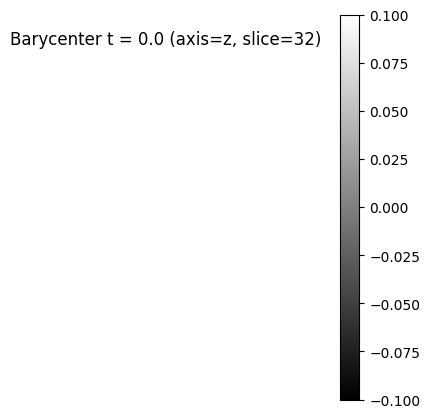

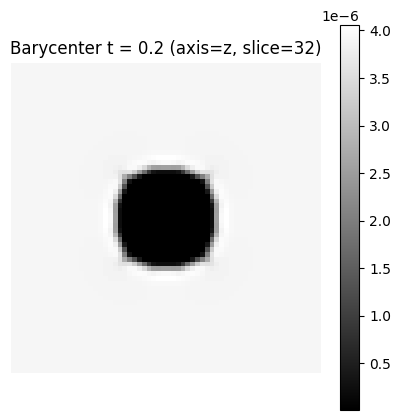

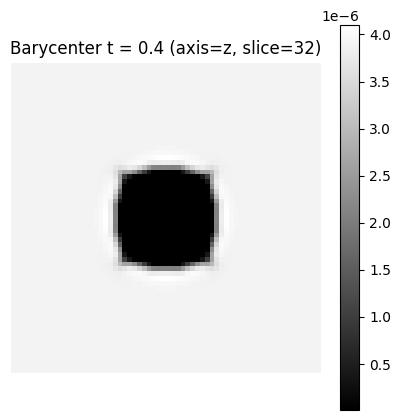

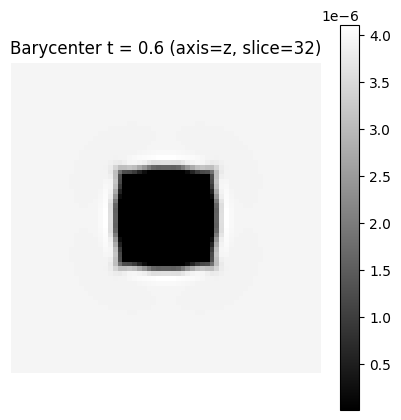

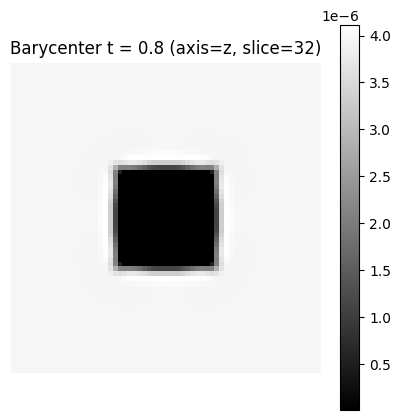

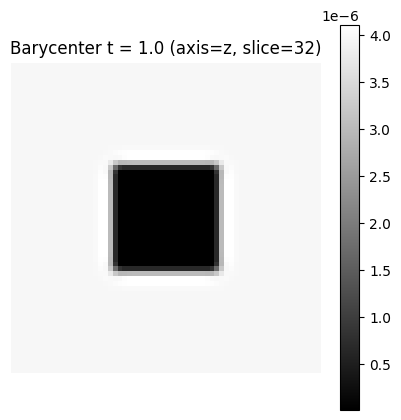

In [50]:
optimal_transport_sdf_blend_with_view(sdf_sphere,sdf_box3D)